# 05 - Analysis - Geothermal Probes
### Author: Daniel Herrera-Russert
#### January 28, 2025

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer # for converting coordinates

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

## 1. Exploratory Data Analysis  

The dataset provides geospatial information about approved geothermal probes (**Erdwärmesonden**) and heat pump installations in **Kanton Zürich**. The dataset is maintained by the **Amt für Abfall, Wasser, Energie und Luft (AWEL)** and is updated daily.  

Originally, the dataset is encoded using the **CH1903+ / LV95 coordinate system** with X/Y values in meters. For the sake of future geographical operations and queries leveraging the potential of GeoJSON files, this will be preserved across all tranformations, and usage of the **WGS-84** coordinates will only be used for visualization libraries which can only handle the international system.

**Mastersonden Attributes** - `zh_geothermal_probes_gdf`
- `gml_id`: Unique identifier for each probe.  
- `x`, `y`: Original Swiss coordinates (CH1903+ / LV95).  
- `lon`, `lat`: Transformed WGS84 coordinates (Longitude & Latitude).  
- `Waermeentnahme`: Heat extraction (kW).  
- `Waermeeintrag`: Heat input (kW).  
- `Sondentiefe`: Bore depth (meters).  
- `Gesamtsondenanzahl`: Total number of bores at the location.  
- `GBS-Nummer`: Unique parcel number associated with the bore.  
- `Bohrprofil`: Indicates whether a bore profile is present (binary flag).  
- `geometry`: Geospatial representation of the probe as a **POINT (lon, lat)**.  

The data is available in multiple formats: **CSV**, **SHP (Shapefile)**, **GeoPackage**, **DXF**, and **ESRI File Geodatabase**. It can be accessed via the **GIS-ZH platform**, **REST API**, or **OpendataSwiss**.

In [2]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_probes.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

In [3]:
# Basic EDA for the dataset
def basic_eda(df):
    # Number of rows and columns
    num_rows, num_columns = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_columns}\n")
    
    # Data types of each column
    print("Data Types:")
    print(df.dtypes)
    print("\n")
    
    # Check for missing values
    print("Missing Values:")
    print(df.isnull().sum())
    print("\n")
    
    # Unique values for categorical variables
    print("Unique Values for Categorical Variables:")
    categorical_columns = df.select_dtypes(include='object').columns
    for col in categorical_columns:
        print(f"{col}: {df[col].nunique()} unique values")
    print("\n")
    
    # Summary statistics for numerical columns
    print("Summary Statistics for Numerical Variables:")
    print(df.describe())
    print("\n")

# Perform basic EDA on the dataset
basic_eda(zh_geothermal_probes_gdf)

Number of rows: 35927
Number of columns: 12

Data Types:
gml_id                object
x                      int32
y                      int32
Waermeentnahme       float64
Waermeeintrag        float64
Sondentiefe            int32
Gesamtsondenzahl     float64
GBS-Nummer            object
Bohrprofil             int32
lon                  float64
lat                  float64
geometry            geometry
dtype: object


Missing Values:
gml_id              0
x                   0
y                   0
Waermeentnahme      0
Waermeeintrag       0
Sondentiefe         0
Gesamtsondenzahl    0
GBS-Nummer          0
Bohrprofil          0
lon                 0
lat                 0
geometry            0
dtype: int64


Unique Values for Categorical Variables:
gml_id: 35927 unique values
GBS-Nummer: 35927 unique values


Summary Statistics for Numerical Variables:
                  x             y  Waermeentnahme  Waermeeintrag  \
count  3.592700e+04  3.592700e+04    35927.000000   35927.000000   
m

In [4]:
active_regen_count = (zh_geothermal_probes_gdf['Waermeeintrag'] > 0).sum()

total_count = len(zh_geothermal_probes_gdf)

active_regen_percentage = (active_regen_count / total_count) * 100

print(f"Active regeneration detected in {active_regen_count} of {total_count} entries.")
print(f"Percentage of entries with active regeneration: {active_regen_percentage:.2f}%")

Active regeneration detected in 3436 of 35927 entries.
Percentage of entries with active regeneration: 9.56%


### **EDA Summary by Variable**  

- **`gml_id`**: Contains unique identifiers for each probe, with all **35,927** values being distinct.  

- **`x` and `y` (Swiss Coordinates, CH1903+ / LV95)**: The coordinates fall within the expected Swiss coordinate system range, with values between **669,640 and 2,714,596 (x)** and **225,567 to 1,283,045 (y)**.  

- **`lon` and `lat` (WGS84 Coordinates)**: Transformed coordinates into **longitude and latitude (EPSG:4326)**. The spatial extent is valid, ranging from **8.3629 to 8.9609 (longitude)** and **47.1733 to 47.6922 (latitude)**, corresponding to Zürich.  

- **`Waermeentnahme` (Heat Extraction in kW)**:  
  - Average extraction is **18.21 kW**, with most probes extracting between **6.5–19.3 kW**.  
  - A significant outlier is observed at **3,658 kW**, indicating potential industrial-scale use or data entry errors.  

- **`Waermeeintrag` (Heat Input in kW)**:  
  - The majority of probes report **0 kW** input.  
  - A few probes have values as high as **4,282 kW**, suggesting locations where heat is injected back into the ground.  

- **`Sondentiefe` (Probe Depth in meters)**:  
  - Average depth is **191.72 meters**, with most probes between **150 and 235 meters**.  
  - An extreme outlier exists at **2,371 meters**, which may indicate deep geothermal projects.  

- **`Gesamtsondenanzahl` (Total Probes per Location)**:  
  - Most locations have **1–3 probes**.  
  - One extreme outlier has **385 probes**, which is significantly higher than typical installations.  

- **`GBS-Nummer`**: Represents unique parcel numbers for each bore. Like `gml_id`, all **35,927 values are unique**, confirming that each probe is linked to a distinct parcel.  

- **`Bohrprofil` (Drilling Profile)**: A binary categorical variable (`0` or `1`) indicating the presence of a drilling profile.  
  - The majority (**87.6%**) have no specific profile (`0`).  
  - Only **12.4%** have a documented drilling profile (`1`).  

- **`geometry`**: Represents spatial data in **POINT (lon, lat)** format. This field ensures compatibility with GIS applications.  

Overall, the dataset contains **no missing values**, ensuring completeness for analysis and modelling. The **spatial distribution of probes is consistent with the Zürich region**, confirming accurate geolocation after coordinate transformation. A few **notable outliers exist**, particularly in **heat extraction, depth, and total probe count**, which should be further analyzed for validity.

---

## 2. Numerical data analysis

### 3.1. Depth

We now direct the attention to the `Sondentiefe` variable to analyze the frequency of probe depths across the dataset. This is done to identify clusters, common depth ranges, and potential outliers.

- **Histogram**: The main plot visualizes the distribution of `Sondentiefe` in bins, showing that the majority of probes have depths concentrated below 500 meters. 
- **Box Plot**: A marginal box plot above the histogram provides a summary of the depth distribution, highlighting the central tendency, variability, and outliers. 
- **Goal**: 
  - To understand the overall structure of the data and detect patterns or irregularities.
  - To confirm suspicions of depth clustering around specific values.
  - To identify outliers or extreme depths that may require further investigation.
- **Findings**: 
  - Most probes are concentrated in a relatively narrow range of depths (approximately 100–300 meters).
  - There are a few outliers with depths exceeding 1000 meters, which may need further exploration or validation.

This analysis helps us better understand the dataset and informs further processing or visualization steps.

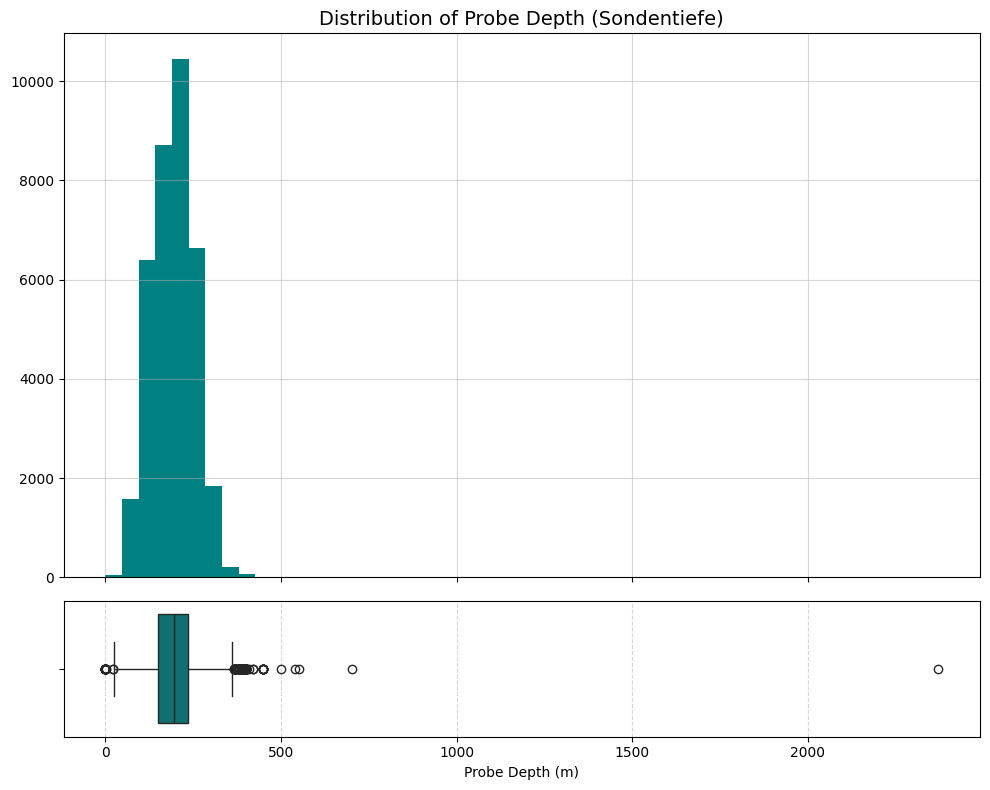

In [8]:
# Set up the figure with two subplots: one above (hist), one below (boxplot)
fig, (ax_hist, ax_box) = plt.subplots(
    2, 1, figsize=(10, 8), gridspec_kw={"height_ratios": [4, 1]}, sharex=True
)

# ---- Histogram on top ----
ax_hist.hist(
    zh_geothermal_probes_gdf["Sondentiefe"],
    bins=50,
    color="teal",
    alpha=1,
    edgecolor=None  # No border around bars
)

ax_hist.set_title("Distribution of Probe Depth (Sondentiefe)", fontsize=14)
ax_hist.grid(True, alpha=0.5)

# ---- Boxplot at bottom ----
# First draw boxplot normally
box = sns.boxplot(
    x=zh_geothermal_probes_gdf["Sondentiefe"],
    color="teal",
    ax=ax_box
)

ax_box.set_xlabel("Probe Depth (m)")
ax_box.grid(True, axis='x', linestyle='--', alpha=0.5)

# Remove y-axis label for boxplot (optional, looks cleaner)
ax_box.set_ylabel("")

# Tight layout and save
plt.tight_layout()
plt.savefig("plots/05_01_02_depth_distribution_combined.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

Upon investigating the outlier with a `Sondentiefe` of **2,371 meters**, it is discovered that corresponds to the [**Zürich Triemli geothermal project**](https://geothermie-schweiz.ch/wp_live/wp-content/uploads/2021/12/ZH_Zuerich-Triemli_DE.pdf). This initiative involves a deep borehole drilled to a depth of 2,371 meters, aiming to explore the potential for geothermal energy extraction in the region. The project's comprehensive analysis includes geological assessments and temperature measurements to evaluate the feasibility of sustainable energy production.

The depth of this borehole is significantly greater than typical geothermal probes, which usually range between 100 to 400 meters, questioning even the very definition of what shallow earth heat probes are. This substantial difference accounts for the outlier observed in our dataset. The detailed findings and methodologies of the Triemli project are documented in the report titled "ZH_Zuerich-Triemli_DE," available on the Geothermie-Schweiz website. This report provides in-depth insights into the project's objectives, drilling processes, and preliminary results, confirming the legitimacy of the recorded depth in our dataset.

It will be thus kept in the dataset and treated as a feature rather than a faulty outlier, and its presence will be evaluated in the future based on its possible effect during the predictive modelling phase.

In [9]:
specific_depth_row = zh_geothermal_probes_gdf[zh_geothermal_probes_gdf['Sondentiefe'] == 2371]

# Check if the row exists before proceeding
if not specific_depth_row.empty:
    # Display the transposed information for better readability
    print("Information for Depth = 2371 (Transposed):")
    print(specific_depth_row.T)
else:
    # Notify if no row with SONDENTIEFE = 2371 exists
    print("No row found with Sondentiefe of exactly 2371.")

Information for Depth = 2371 (Transposed):
                                            19693
gml_id                    erdwaermesonden.1490692
x                                         2679653
y                                         1246871
Waermeentnahme                              300.0
Waermeeintrag                                 0.0
Sondentiefe                                  2371
Gesamtsondenzahl                              1.0
GBS-Nummer                             b 00-10523
Bohrprofil                                      1
lon                                      8.493173
lat                                     47.367866
geometry          POINT (2679652.888 1246870.867)


---

### 3.2. Heat Extraction vs. Depth

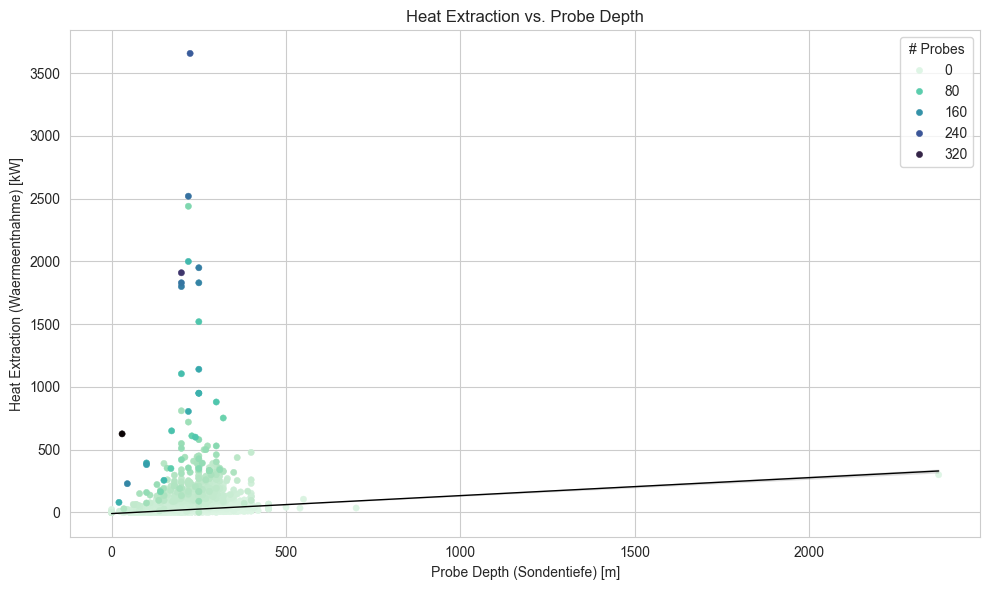

In [10]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Sort so high "Gesamtsondenzahl" values plot last
sorted_df = zh_geothermal_probes_gdf.sort_values(by="Gesamtsondenzahl", ascending=True)

# Use scatterplot for color encoding
sns.scatterplot(
    data=sorted_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="mako_r",  # or "coolwarm", "magma", etc.
    alpha=1,
    s=20,
    edgecolor=None,
)

# Add regression line (ignoring hue, purely for trend)
sns.regplot(
    data=zh_geothermal_probes_gdf,
    x="Sondentiefe",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

plt.title("Heat Extraction vs. Probe Depth")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Heat Extraction (Waermeentnahme) [kW]")
plt.legend(title="# Probes")
plt.tight_layout()
plt.savefig("plots/05_03_heat_extraction_vs_depth.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/05_03_heat_extraction_vs_depth.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

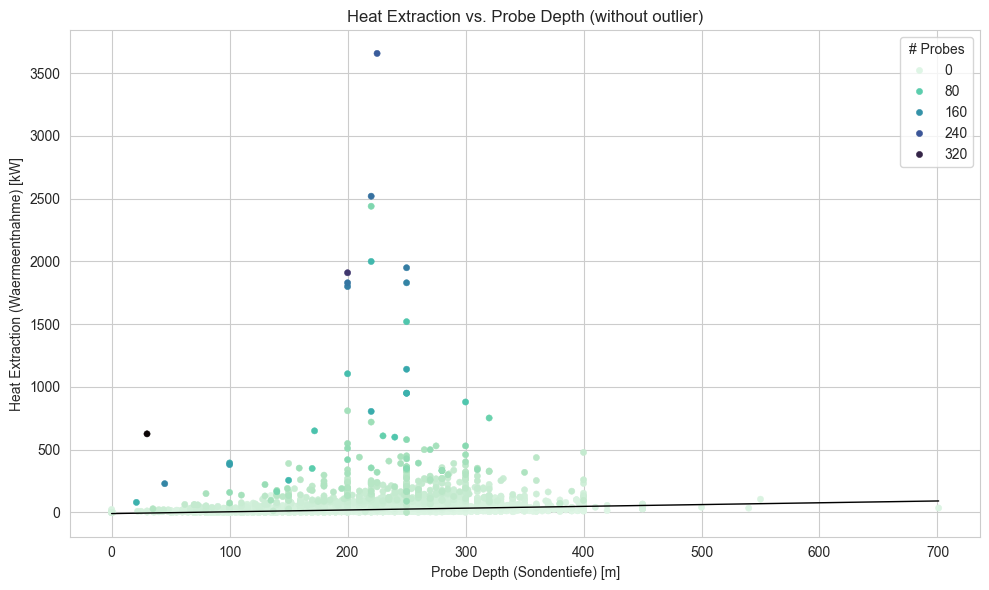

In [11]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

filtered_df = sorted_df[sorted_df["Sondentiefe"] < 2000]

# Use scatterplot for color encoding
sns.scatterplot(
    data=filtered_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="mako_r",  # or "coolwarm", "magma", etc.
    alpha=1,
    s=20,
    edgecolor=None,
)

# Add regression line (ignoring hue, purely for trend)
sns.regplot(
    data=filtered_df,
    x="Sondentiefe",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

plt.title("Heat Extraction vs. Probe Depth (without outlier)")
plt.xlabel("Probe Depth (Sondentiefe) [m]")
plt.ylabel("Heat Extraction (Waermeentnahme) [kW]")
plt.legend(title="# Probes")
plt.tight_layout()
plt.savefig("plots/05_04_heat_extraction_vs_depth.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/05_04_heat_extraction_vs_depth.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

---

## 3. Geographic Interpretation of the Data

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


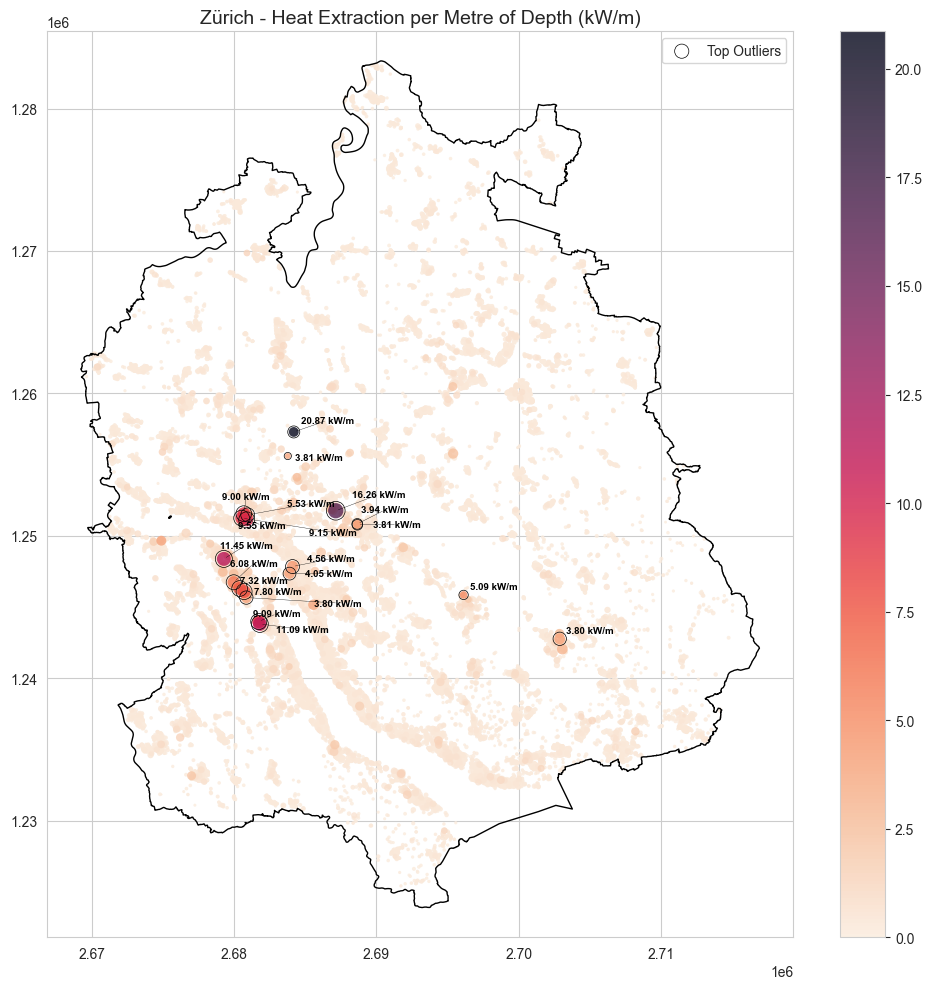

In [12]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Load and ensure Zürich boundary is in LV95
boundary_gdf = gpd.read_file("../data/raw/zh_boundary.geojson").to_crs("EPSG:2056")

# Remove invalid rows (depth = 0 or missing)
valid_df = zh_geothermal_probes_gdf[
    (zh_geothermal_probes_gdf["Sondentiefe"] > 0) &
    (~zh_geothermal_probes_gdf["Sondentiefe"].isna())
].copy()

# Compute heat per meter
valid_df["heat_per_depth"] = valid_df["Waermeentnahme"] / valid_df["Sondentiefe"]

# Sort by heat per meter
valid_df.sort_values("heat_per_depth", ascending=True, inplace=True)

# Scale marker sizes
valid_df["scaled_size"] = np.sqrt(valid_df["Waermeentnahme"] + 1) * 2

# Identify top top 20 highest heat_per_depth
top_outliers = valid_df.sort_values("heat_per_depth", ascending=False).head(20)

# Alternative: pick top 10
# top_outliers = valid_df.sort_values("heat_per_depth", ascending=False).head(10)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))


# Plot points
scatter = ax.scatter(
    valid_df.geometry.x,
    valid_df.geometry.y,
    c=valid_df["heat_per_depth"],
    cmap="rocket_r",
    s=valid_df["scaled_size"],
    alpha=0.8,
    edgecolor="none"
)

# Plot Zürich canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Highlight outliers with a different edge color
ax.scatter(
    top_outliers.geometry.x,
    top_outliers.geometry.y,
    facecolors='none',
    edgecolors='black',
    s=top_outliers["scaled_size"] * 1.5,
    linewidths=0.5,
    label="Top Outliers"
)

# Annotate and collect all text objects (LABEL HEAT PER DEPTH!)
texts = []
for idx, row in top_outliers.iterrows():
    texts.append(
        ax.text(
            row.geometry.x,
            row.geometry.y,
            f"{row['heat_per_depth']:.2f} kW/m",
            fontsize=7,
            color="black",
            weight='bold',
            ha='left',
            va='bottom'
        )
    )

# Adjust the texts automatically to prevent overlaps
adjust_text(
    texts,
    ax=ax,
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.25)
)
# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)

# Final touches
plt.title("Zürich - Heat Extraction per Metre of Depth (kW/m)", fontsize=14)
plt.axis("equal")
plt.legend()
plt.tight_layout()

# Save
plt.savefig("plots/05_05_heat_extraction_vs_depth_map_annotated.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
top_outliers.head()[["gml_id", "Waermeentnahme", "heat_per_depth", "Gesamtsondenzahl"]]

,gml_id,Waermeentnahme,heat_per_depth,Gesamtsondenzahl
4370,erdwaermesonden.1469314,626.0,20.866667,385.0
1986,erdwaermesonden.1466602,3658.0,16.257778,232.0
17012,erdwaermesonden.1495452,2520.0,11.454545,205.0
19771,erdwaermesonden.1494164,2440.0,11.090909,61.0
34714,erdwaermesonden.1517579,1910.0,9.550000,287.0


18 [-0.6144914  0.5183612]
19 [-0.72159315 -0.69163375]


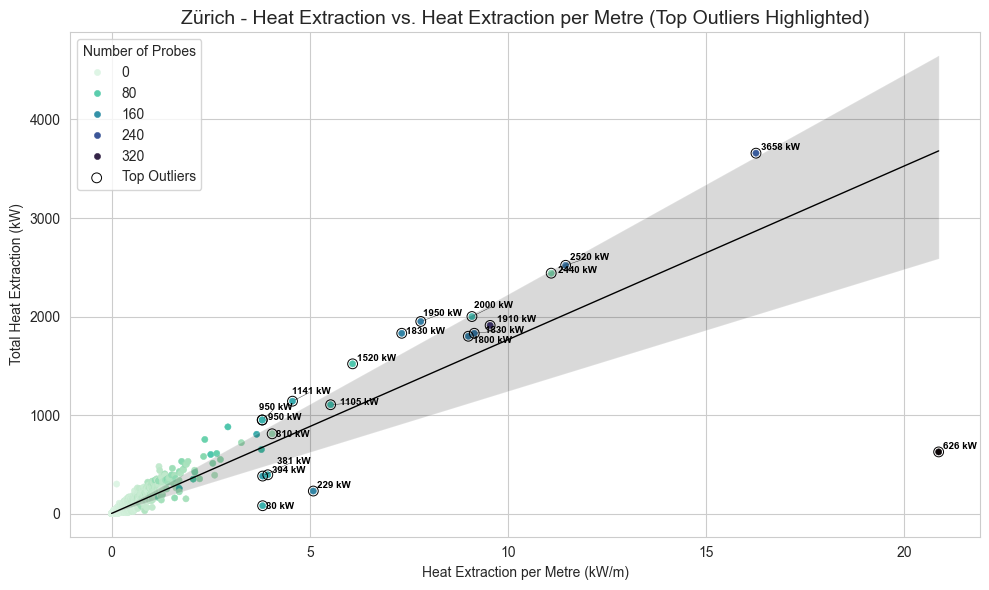

In [14]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Scatterplot all data
sns.scatterplot(
    data=valid_df,
    x="heat_per_depth",
    y="Waermeentnahme",
    hue="Gesamtsondenzahl",
    palette="mako_r",
    alpha=1,
    s=20,
    edgecolor=None,
)

# Plot the same outliers
plt.scatter(
    top_outliers["heat_per_depth"],
    top_outliers["Waermeentnahme"],
    facecolors='none',
    edgecolors='black',
    s=50,  # slightly larger so they pop out
    linewidths=0.7,
    label="Top Outliers"
)

# Annotate the outliers
texts = []
for idx, row in top_outliers.iterrows():
    texts.append(
        plt.text(
            row["heat_per_depth"],
            row["Waermeentnahme"],
            f"{row['Waermeentnahme']:.0f} kW",
            fontsize=7,
            color="black",
            weight='bold',
            ha='left',
            va='bottom'
        )
    )

# Adjust the texts automatically
adjust_text(
    texts,
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.25)
)

# Add a regression line (over all points, no hue)
sns.regplot(
    data=valid_df,
    x="heat_per_depth",
    y="Waermeentnahme",
    scatter=False,
    line_kws={"color": "black", "linewidth": 1},
)

# Titles and labels
plt.title("Zürich - Heat Extraction vs. Heat Extraction per Metre (Top Outliers Highlighted)", fontsize=14)
plt.xlabel("Heat Extraction per Metre (kW/m)")
plt.ylabel("Total Heat Extraction (kW)")

# Legend
plt.legend(title="Number of Probes", loc="best")

# Layout and save
plt.tight_layout()
plt.savefig("plots/05_06_heat_extraction_vs_heat_per_depth_with_outliers.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

A question arises of whether boreholes across the canton of Zürich will yield similar amounts of thermal energy when installed at comparable depths. This analysis is grounded in the hypothesis that subsurface temperatures—and thus geothermal potential—are relatively uniform at a given depth, regardless of geographic location within the canton.

To explore this, we will categorize borehole depths into discrete bins (e.g., 180–190 m, 190–200 m, etc.). Each geothermal installation will be assigned to a depth bin based on its reported `Sondentiefe` (probe depth). For each bin, we will visualize the spatial distribution of extracted power (`Waermeentnahme`) across the canton.

The visualization will consist of individual maps for each depth category, showing the location of probes within that depth bin and coloring each point by its extracted heat output. If the assumption of thermal uniformity holds, we would expect to see relatively consistent values of extracted power across the canton for probes in the same depth category. Conversely, noticeable spatial variation may indicate that subsurface temperatures, and hence geothermal potential, vary with local geology even at the same depth.

In [15]:
bin_edges = list(range(0, 401, 10))  # 150–160, 160–170, ..., 240–250

# Create depth bin labels (e.g. "150–160")
bin_labels = [f"{b}-{b+10}" for b in bin_edges[:-1]]

# Assign bins to a new column
zh_geothermal_probes_gdf["depth_bin"] = pd.cut(
    zh_geothermal_probes_gdf["Sondentiefe"],
    bins=bin_edges,
    labels=bin_labels,
    include_lowest=True
)

# Keep only rows with valid depth and heat data
plot_df = zh_geothermal_probes_gdf[
    zh_geothermal_probes_gdf["depth_bin"].notna() &
    (zh_geothermal_probes_gdf["Waermeentnahme"] > 0)
].copy()

C:\Users\leina\AppData\Local\Temp\ipykernel_34796\3340068582.py:50: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


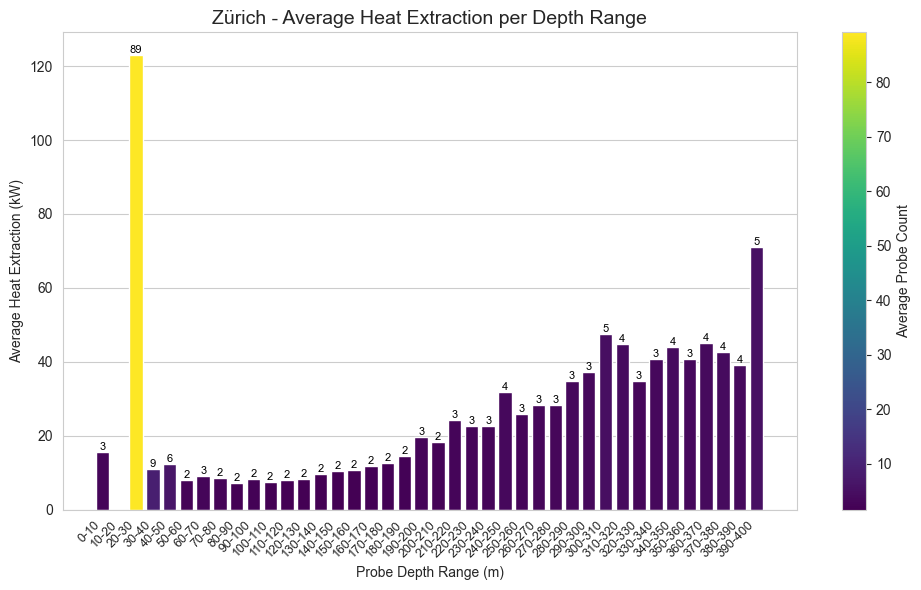

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Group by depth bin and calculate mean values
mean_values = plot_df.groupby("depth_bin", observed=False)[["Waermeentnahme", "Gesamtsondenzahl"]].mean().reset_index()

# Normalize Gesamtsondenzahl for color mapping
norm = plt.Normalize(mean_values["Gesamtsondenzahl"].min(), mean_values["Gesamtsondenzahl"].max())
cmap = plt.cm.viridis
colors = cmap(norm(mean_values["Gesamtsondenzahl"]))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

bars = ax.bar(
    mean_values["depth_bin"],
    mean_values["Waermeentnahme"],
    color=colors
)

# Add text annotations on bars for Gesamtsondenzahl
for bar, label in zip(bars, mean_values["Gesamtsondenzahl"]):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{label:.0f}',  # Show as integer
        ha='center',
        va='bottom',
        fontsize=8,
        color='black'
    )

# Colorbar with explicit axis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Average Probe Count")

# Titles and labels
ax.set_title("Zürich - Average Heat Extraction per Depth Range", fontsize=14)
ax.set_xlabel("Probe Depth Range (m)")
ax.set_ylabel("Average Heat Extraction (kW)")
ax.grid(axis='x', visible=False)  # Turn off vertical grid lines

# Rotate x-ticks
ax.set_xticklabels(mean_values["depth_bin"], rotation=45, ha='right', fontsize=9)

# Layout and save
plt.tight_layout()
plt.savefig("plots/05_07_average_heat_extraction_per_depth_bin_colored_labeled.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

To ensure meaningful color differentiation in the legend, we recommend setting the range for `Waermeentnahme` between **0 and 50 kW**. This interval captures the vast majority of typical borehole installations, which mostly fall between 6.5 and 20 kW, while compressing only a small number of high-yield outliers. It avoids visual washout caused by extreme values like the 3,658 kW maximum and keeps the legend scale consistent and interpretable across all depth-bin plots.
